In [1]:
from jax import numpy as jnp
from jax import random, jit, Array
import numpy as np
import phayes as bys
import matplotlib.pyplot as plt

In [26]:
# Gate Declerations
theta = np.pi / 10

#P = jnp.array([[1, 0], [0, jnp.exp(1.j * theta / 2)]])
P = jnp.array([[1, 0], [0, jnp.exp(1.j * np.pi / 2)]])

def Rz(theta):
    jnp.array([[np.exp(- 0.5j * np.pi), theta - theta], [0, jnp.exp(0.5j * np.pi)]])

#def Rz(theta):
#    jnp.array([[np.exp(- 0.5j * theta), 0], [0, jnp.exp(0.5j * theta)]])

H = jnp.array([[1, 1], [1, -1]]) / jnp.sqrt(2)

def C_U(theta):
    Rz = jnp.array([[np.exp(- 0.5j * theta), 0], [0, jnp.exp(0.5j * theta)]])
    C_U = jnp.kron(P, H @ Rz @ H)
    return C_U

#U = jnp.kron(P, H @ Rz(theta) @ H)

In [27]:
#True Phase calculator
e_vs, e_vecs = jnp.linalg.eig(U(theta))
orthoganal = 0 # Set to 0 if true
x_vec = e_vecs[:, orthoganal]
true_phase = np.arccos(e_vs[orthoganal].real)
jnp.allclose(U(theta) @ x_vec, jnp.exp(1.j * true_phase) * x_vec)

TypeError: jnp.linalg.eig requires ndarray or scalar arguments, got <class 'function'> at position 0.

In [15]:
# Mass Hadamard Generator
n_qubits_U = int(np.log2(U.shape[0]))

big_H = jnp.kron(H, jnp.eye(U.shape[0]))
in_statevector = jnp.kron(jnp.array([1, 0]), x_vec)

In [16]:
def build_bayes_circ(k: int, beta: float) -> jnp.ndarray:
    k = int(k)
    big_Rz = jnp.kron(Rz(beta), jnp.eye(U.shape[0]))
    U_k = jnp.linalg.matrix_power(U, k)
    controlled_U_k = jnp.block([[jnp.eye(U.shape[0]), jnp.zeros(U.shape)], [jnp.zeros(U.shape), U_k]])
    
    out_statevector = big_H @ controlled_U_k @ big_Rz @ big_H @ in_statevector
    meas = jnp.abs(out_statevector) ** 2
    meas_q1 = meas.reshape((2, ) * (n_qubits_U + 1)).sum(axis=tuple(range(1, n_qubits_U + 1)))
    return meas_q1


def gen_circs(k: int, beta: float, n_shots: int, random_key: Array) -> jnp.ndarray:
    bayes_result = build_bayes_circ(k, beta)
    return random.choice(random_key, a=jnp.arange(2), p=bayes_result, shape=(n_shots,))

In [9]:
# Check the phase satisfies eigenvector equation
# note: this can be used to check post solves
k_test = 4
beta_test = 0.43543
jnp.isclose(build_bayes_circ(k_test, beta_test)[0], 0.5 * (1 + jnp.cos(k_test * true_phase + beta_test)))

shots = gen_circs(k_test, beta_test, 10000, random.key(0))
jnp.isclose(1 - shots.mean(), 0.5 * (1 + jnp.cos(k_test * true_phase + beta_test)), atol=1e-2)

Array(True, dtype=bool)

In [10]:
# Estimate that Phase
def bayes_iterator(prior_state: jnp.ndarray, n_shots: int, random_key: Array) -> jnp.ndarray:
    k, beta = jit(bys.get_k_and_beta)(prior_state)
    shots = gen_circs(k, beta, n_shots, random_key)
    posterior_state = jit(bys.update)(prior_state, shots, k, beta)
    return beta, k, posterior_state

In [20]:
def bqpe(n: int, betas, ks, states):
    states = [bys.init(fourier_coes)]
    ks = []
    betas = []
    shots = 10
    random_keys = random.split(random.key(0), n_rounds)
    for i in range(n_rounds):
        beta, k, new_state = bayes_iterator(states[i], shots, random_keys[i])
        
        print(f"Experiment {i + 1} of {n_rounds}, k={k}, beta={beta:.2f}, coeffs used: {(new_state.fourier_coefficients != 0).sum() // 2}/{new_state.fourier_coefficients[0].size}")
    
        states.append(new_state)
        ks.append(k)
        betas.append(beta)

In [22]:
# MAIN
## Set number of iterations with n_rounds
n_rounds = 5

## Number of fourier coefficents. Warning this is mem heavy!
fourier_coes = 100 



bqpe(n_rounds, betas, ks, states)

Experiment 1 of 4, k=1, beta=1.57, coeffs used: 9/100
Experiment 2 of 4, k=3, beta=1.57, coeffs used: 40/100
Experiment 3 of 4, k=1, beta=0.00, coeffs used: 50/100
Experiment 4 of 4, k=11, beta=0.35, coeffs used: 0/100


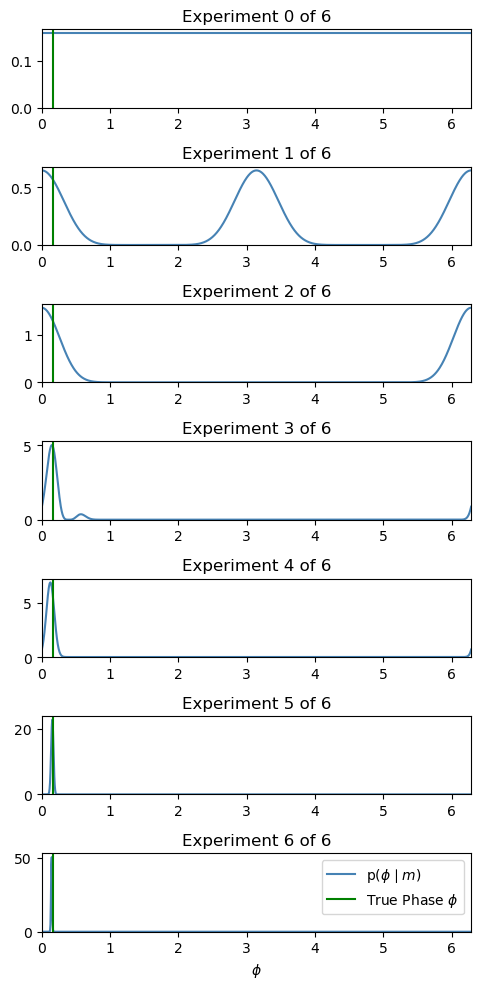

In [19]:
pdf_linsp = jnp.linspace(0, 2 * jnp.pi, 1000)

fig, axes = plt.subplots(n_rounds + 1, figsize=(5, 10))
for i in range(n_rounds + 1):
    axes[i].plot(pdf_linsp, bys.pdf(pdf_linsp, states[i]), c='steelblue', label=f'p($\phi \mid m)$')
    axes[i].axvline(true_phase, color='green', label=r'True Phase $\phi$')
    axes[i].set_title(f"Experiment {i} of {n_rounds}")
    axes[i].set_xlim(0, 2 * jnp.pi)
    axes[i].set_ylim(0, axes[i].get_ylim()[1])
axes[-1].set_xlabel(r'$\phi$')
axes[-1].legend()
fig.tight_layout()